In [1]:
try:
    # Comment out if not using colab
    from google.colab import drive
    drive.mount('/content/drive')

    # Specific for luca's computer
    %cd "/content/drive/Othercomputers/Min MacBook Pro/INFO381-GitHub"
    using_colab = True
except:
    print("Not using Google Colab")
    using_colab = False

Mounted at /content/drive
/content/drive/Othercomputers/Min MacBook Pro/INFO381-GitHub


In [ ]:
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision.models as models

import torchvision
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

import time
from sklearn.model_selection import KFold

### Define train and test path

In [ ]:
path_train = "cifar_train_test/train"
path_test = "cifar_train_test/test"

### Image preprocessing

In [ ]:
transform = transforms.Compose([
    #transforms.Resize((128, 128)),  # Resize images to 128x128
    #transforms.RandomAffine(0, shear = 10, scale = (0.8,1.2)), #Performs actions like zooms, change shear angles.
    #transforms.ColorJitter(brightness = 0.2, contrast = 0.2, saturation = 0.2), # Set the color params
    transforms.ToTensor()  # Convert images to PyTorch tensors
    #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #Normalize all the images
])

#Har lagt inn litt forslag til forskjellige transforms vi kan ha, litt usikker på om det er vits? Gjør bare at bildene blir styggere

### Create the datasets with ImageFolder

Automatically reads the REAL and FAKE folders and lables them

In [ ]:
train_dataset = ImageFolder(root = path_train, transform = transform)
test_dataset = ImageFolder(root = path_test, transform = transform)

# DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Function to show images

In [ ]:
def show_batch(data_loader, num_images):
    class_names = train_dataset.classes  # Fake and real lables instead of 1 and 0

    data_iter = iter(data_loader)
    images, labels = next(data_iter)

    plt.figure(figsize=(20, 4))
    for i in range(min(num_images, len(images))):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[i].permute(1, 2, 0))
        plt.title(f"Label: {class_names[labels[i].item()]}")
        plt.axis('off')

    plt.show()

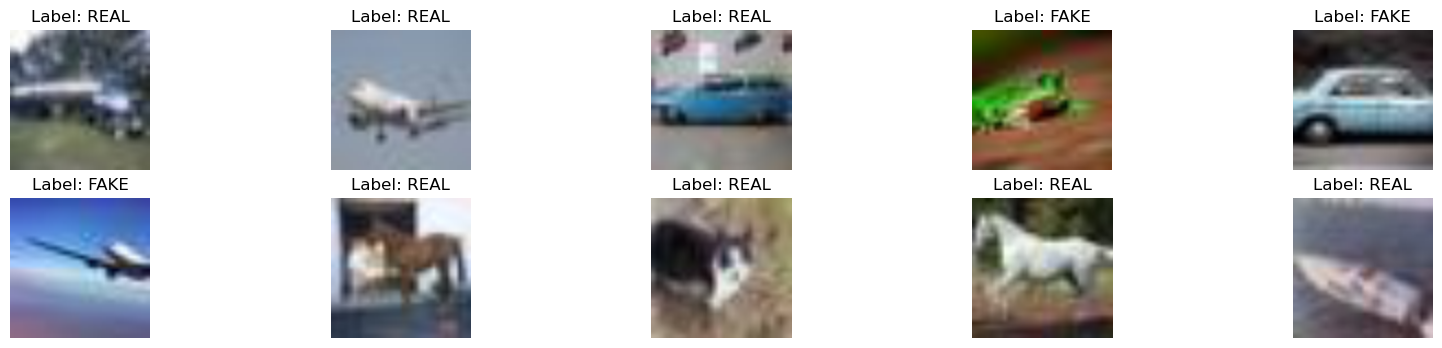

In [ ]:
show_batch(train_loader, num_images = 10)

### Defining the model

Using the pre-trained ResNet18.
Resnet-18 is trained on the huge ImageNet dataset, which contains more than 1 million images

In [ ]:
model = models.resnet18(pretrained = True)

/Users/ot/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/ot/opt/anaconda3/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Modify the final layer to match 2 classes (fake and real)

In [ ]:
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, 2)

In [ ]:
# Use GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### Training the model

In [ ]:
num_epochs = 10

for epoch in range(num_epochs):
    start_time = time.time()

    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the gradients
        outputs = model(inputs)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Update weights

        running_loss += loss.item()  # Track loss

        # Calculate accuracy
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    # Calculate average loss and accuracy for this epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct / total * 100

    # End time for this epoch
    end_time = time.time()
    epoch_time = end_time - start_time

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.2f}%, Time: {epoch_time:.2f} seconds")

# After training, save the model
torch.save(model.state_dict(), "resnet18_cnn.pth")
print("Model saved successfully!")

Epoch [1/1], Loss: 0.1945, Accuracy: 92.36%, Time: 3579.43 seconds
Model saved successfully!
